# Assignment 1

### MACS 30250, Dr. Evans
### Dongcheng Yang  

problem 1

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook
bq_data = np.loadtxt('data\BQmat_orig.txt', delimiter=',')

In [5]:
print('Shape of bq_data', bq_data.shape)
print('Bequest distribution by income group:',
      bq_data.sum(axis=0))
print('Sum of all probabilities', bq_data.sum())

Shape of bq_data (78, 7)
Bequest distribution by income group: [0.01214584 0.00817072 0.01590964 0.0139963  0.01383075 0.06927237
 0.86667437]
Sum of all probabilities 1.0


(a)

<IPython.core.display.Javascript object>


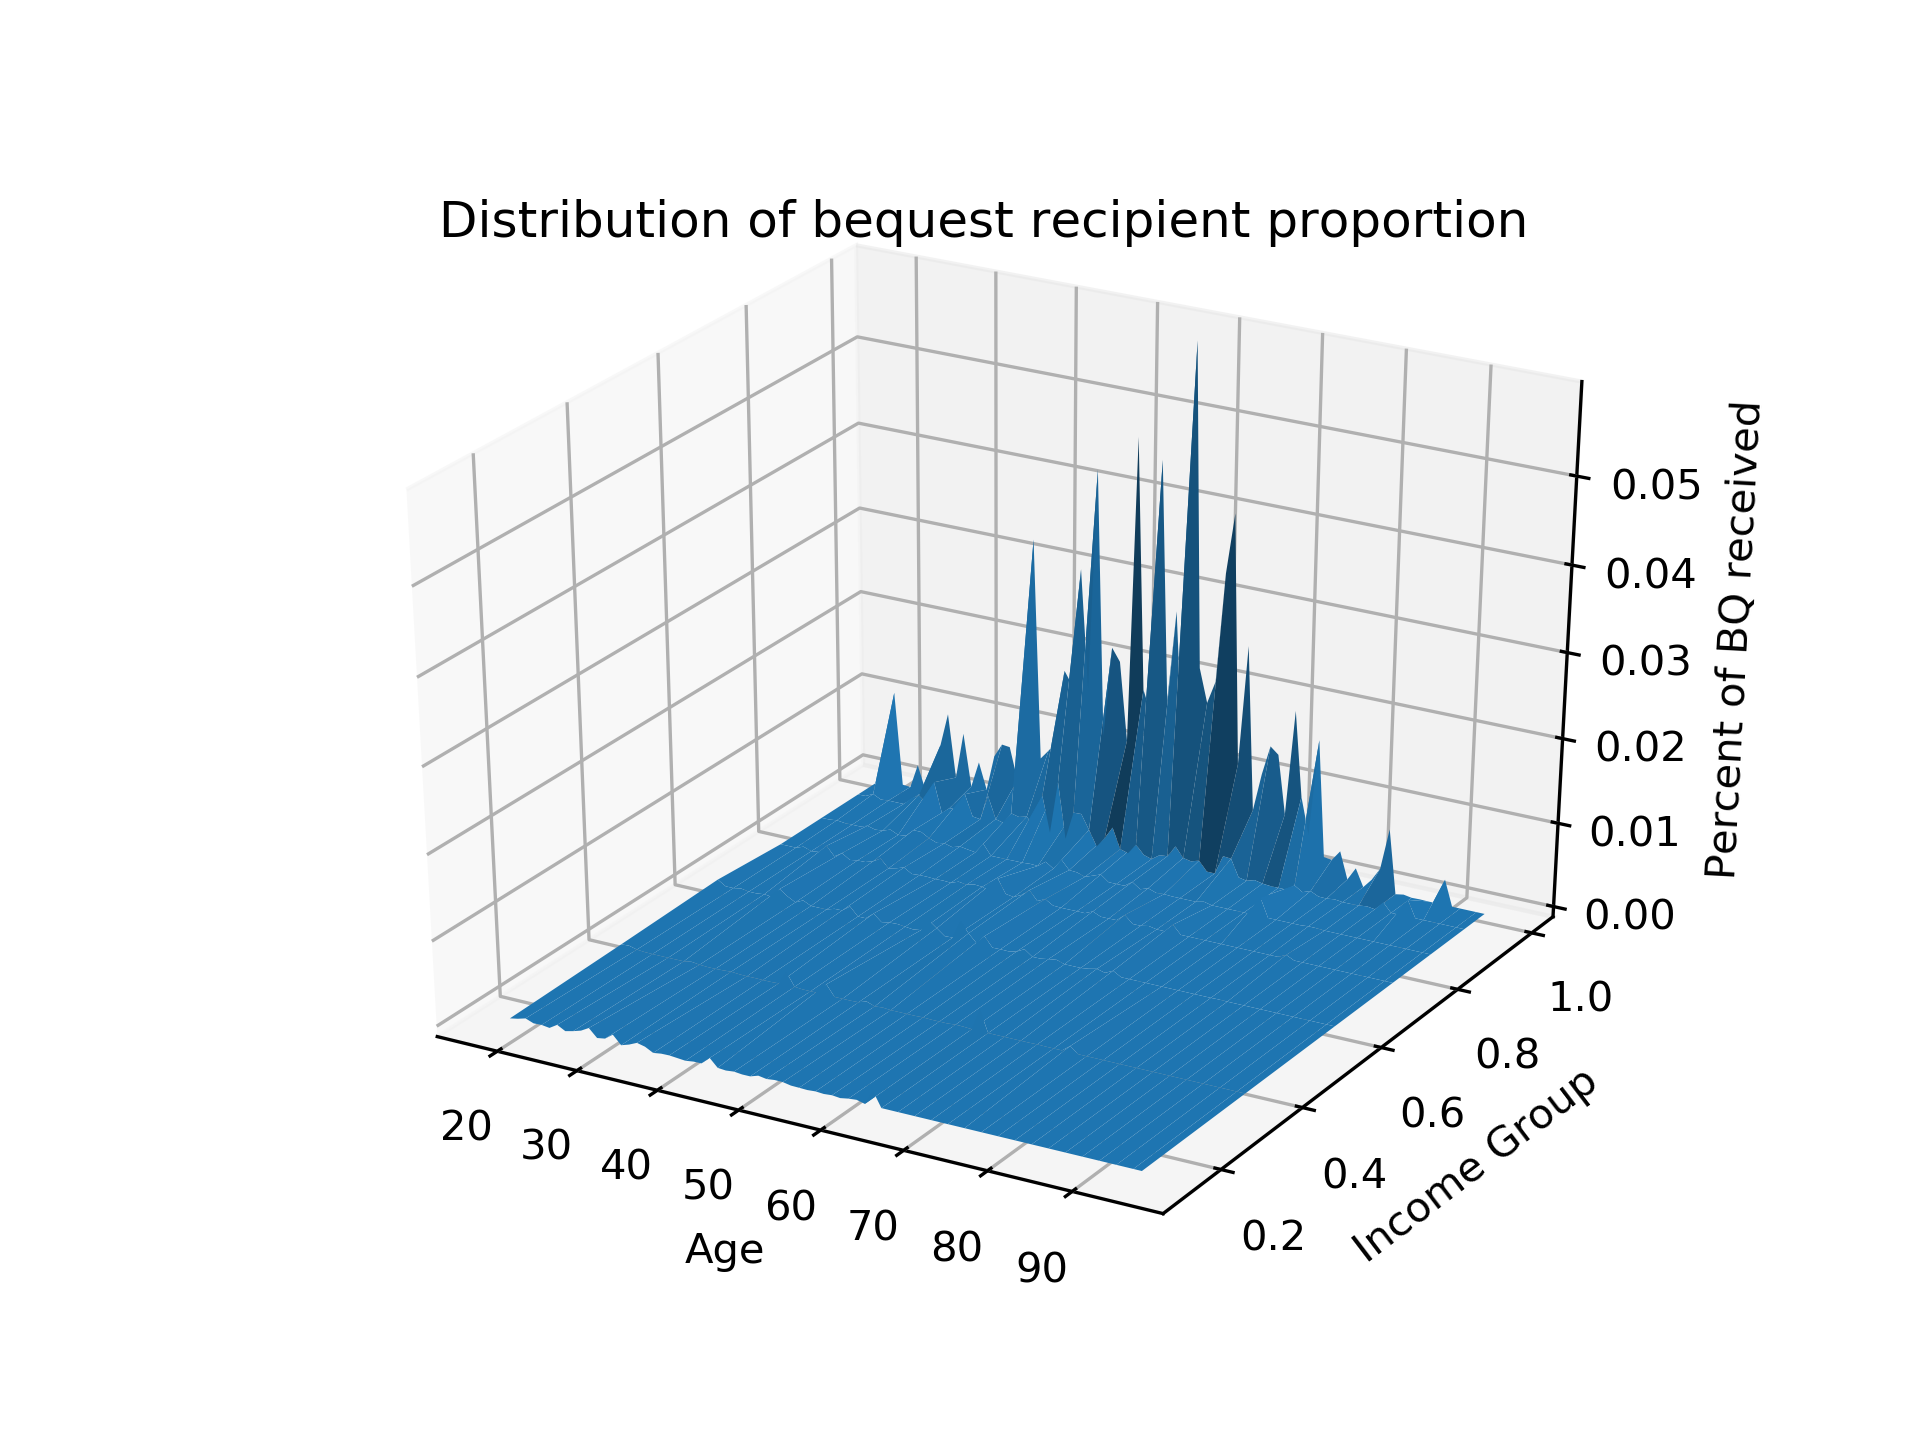

Text(0.5, 0, 'Percent of BQ received')

In [6]:
## Because the sum already equals to 1, no need to rescale
age_vec = np.arange(18, 96)
lambdas = np.array([0.25, 0.25, 0.20, 0.10, 0.10, 0.09, 0.01])
lambdas_mdpts = np.array([0.125, 0.375, 0.60, 0.75, 0.85,
                          0.94, 0.995])
income_mat, age_mat = np.meshgrid(lambdas_mdpts, age_vec)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(age_mat, income_mat, bq_data)
ax.set_title('Distribution of bequest recipient proportion')
ax.set_xlabel('Age')
ax.set_ylabel('Income Group')
ax.set_zlabel('Percent of BQ received')

(b)

In [7]:
# simulate data
bq_data_pd = pd.DataFrame(bq_data)
bq_data_pd.index = age_vec
bq_data_pd.columns = lambdas_mdpts

data_1d = pd.DataFrame()
for row in bq_data_pd.index:
    for col in bq_data_pd.columns:
        data_1d= data_1d.append([[row, col, bq_data_pd.loc[row][col]]])
data_1d.index = np.arange(0, 546)
data_1d.columns = ['age', 'group', 'prob']

data_sim = pd.DataFrame()
index = np.random.choice(546, 10000, p = data_1d['prob'])
data_sim = data_1d.iloc[index][['age', 'group']]
data_sim.head()

,age,group
153,39,0.995
432,79,0.940
216,48,0.995
223,49,0.995
258,54,0.995


<IPython.core.display.Javascript object>


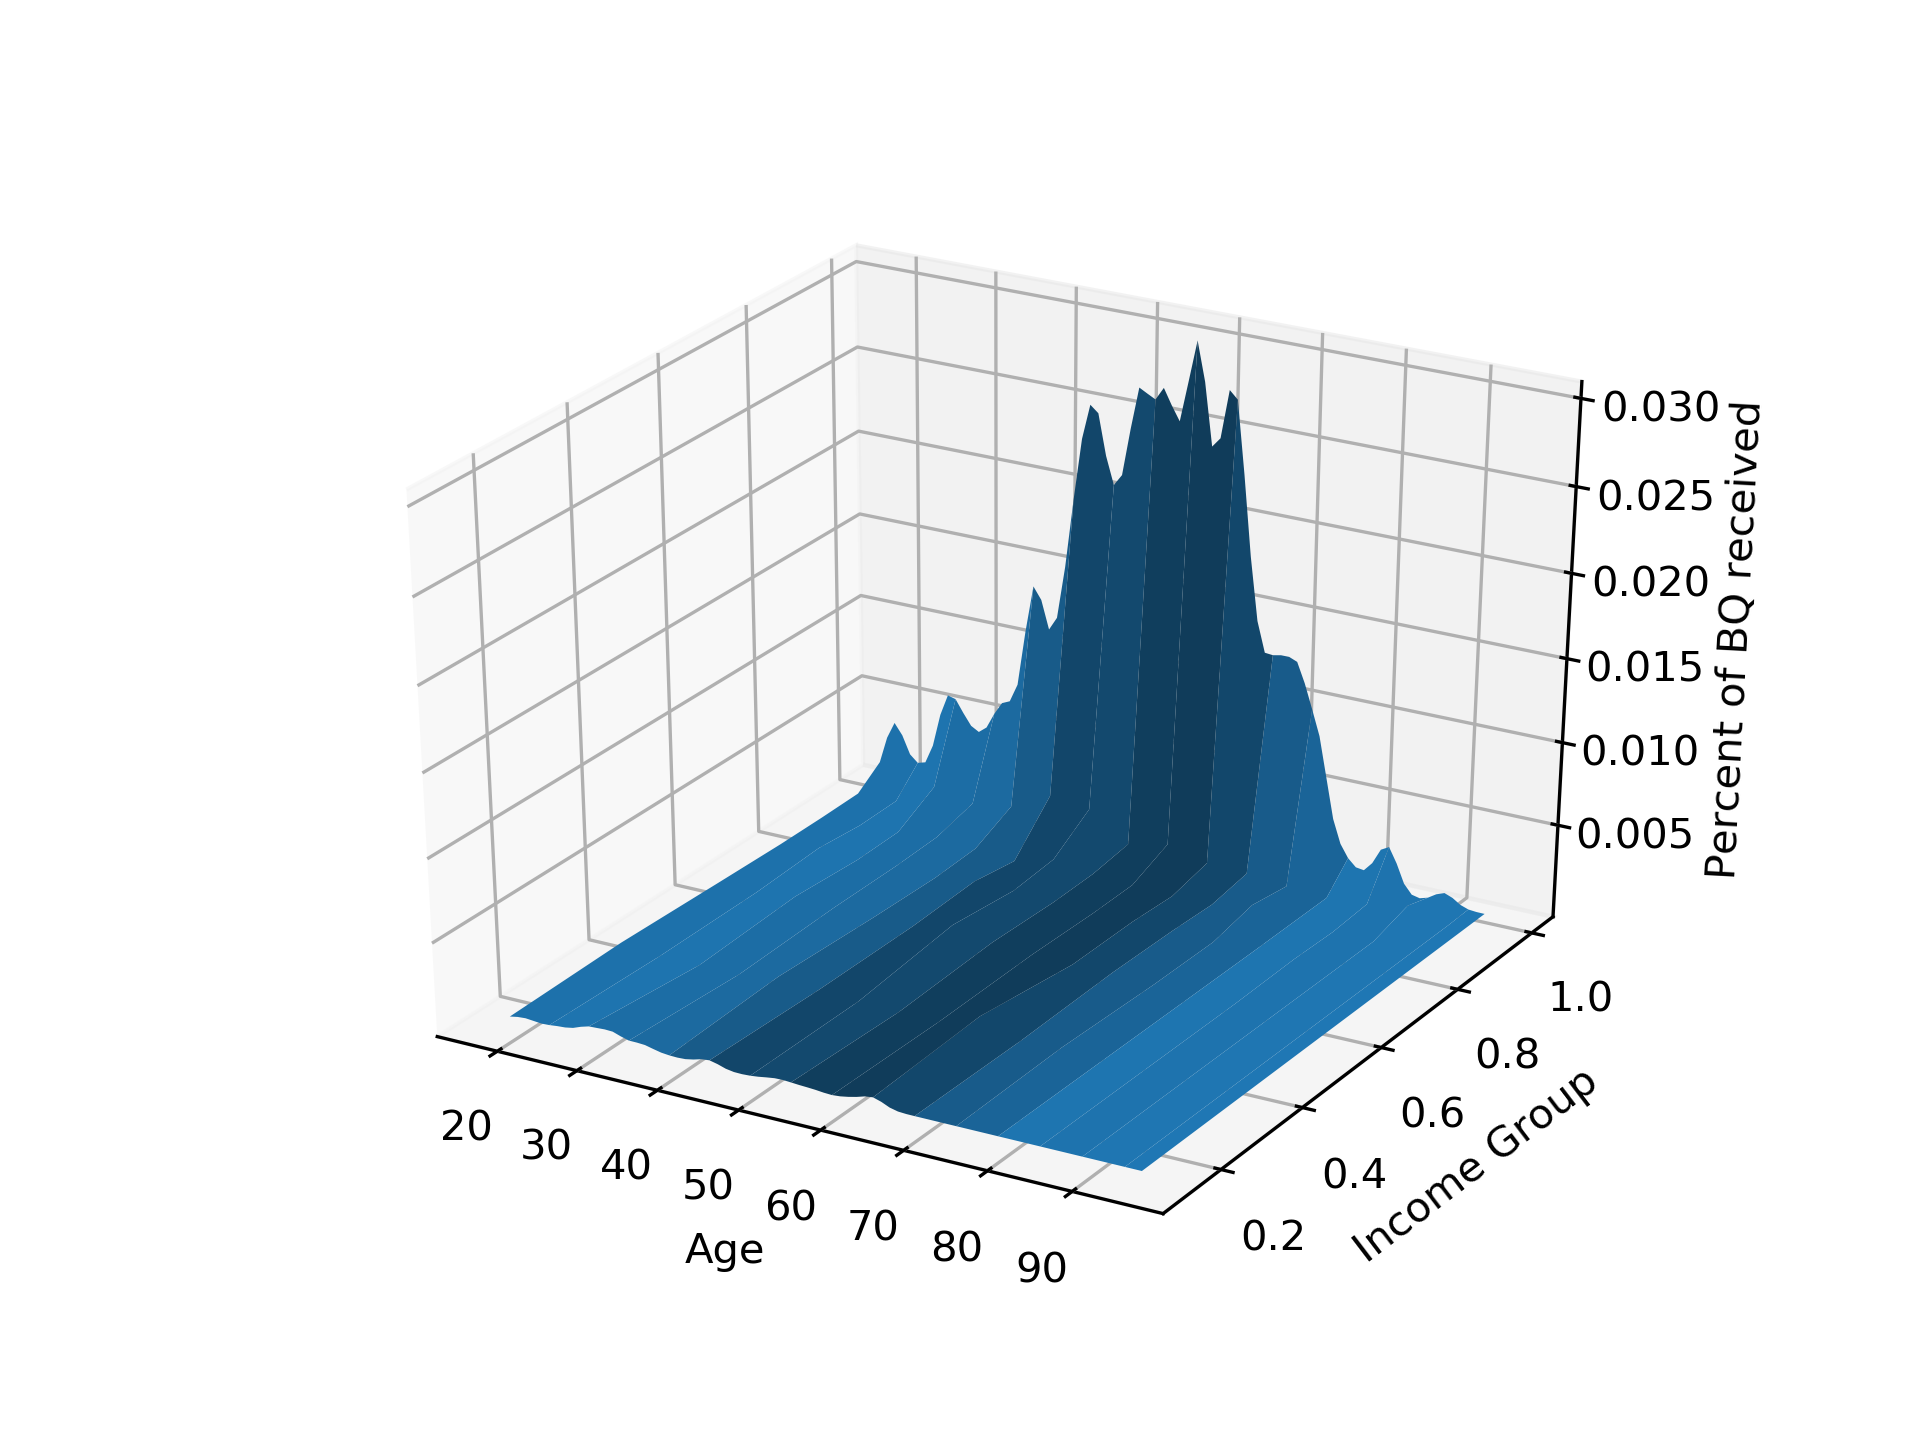

Text(0.5, 0, 'Percent of BQ received')

In [8]:
from scipy.stats import gaussian_kde

bandwidth = 0.1
kernel = gaussian_kde(data_sim.T, bw_method=bandwidth)

coords = np.vstack([item.ravel() for item in [age_mat, income_mat]])

Z = np.reshape(kernel(coords), age_mat.shape)
Z_scaled = Z / float(np.sum(Z))

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(age_mat, income_mat, Z_scaled, rstride=5)
ax.set_xlabel('Age')
ax.set_ylabel('Income Group')
ax.set_zlabel('Percent of BQ received')

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from sklearn.model_selection  import KFold
import warnings
warnings.filterwarnings("ignore")

bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv= KFold(10))
grid.fit(bq_data[:, ])
grid.best_params_["bandwidth"]

0.1

Cross validation verifies that the choice of bandwith 0.1 is decent.

In [15]:
print("Estimated density for age 61 in the 6th lifetime income category:", Z_scaled[43,5])
print("Real density for age 61 in the 6th lifetime income category:", bq_data[43,5])

Estimated density for age 61 in the 6th lifetime income category: 0.0010316755501069196
Real density for age 61 in the 6th lifetime income category: 0.0008630400696026425


The former results show that the estimated density is pretty close to the real density.

problem 2

In [16]:
df1 = pd.read_csv('data\Auto.csv',na_values="?")
df1.dropna(inplace=True)
df1.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


In [17]:
import warnings
warnings.filterwarnings("ignore")

tf = df1['mpg']>=df1['mpg'].median()
df1['mpg_high'] = np.where(tf,1,0)

df1['orgn1'] = 0
df1.orgn1[df1['origin']==1] = 1
df1['orgn2'] = 0
df1.orgn2[df1['origin']==2] = 1

df1.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg_high,orgn1,orgn2
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu,0,1,0
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320,0,1,0
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite,0,1,0
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst,0,1,0
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino,0,1,0


(a)

In [18]:
import timeit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

y = df1['mpg_high'].values
X = df1[['cylinders', 'displacement', 'horsepower', 'weight','acceleration', 'year', 'orgn1', 'orgn2']].values
start_time = timeit.default_timer()
mse = []
for i in range(100):
    j = i+1
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.35, random_state=j)
    LR = LogisticRegression(solver='lbfgs', max_iter=2000, n_jobs=1)
    LR.fit(X_train, y_train)
    y_pred = LR.predict(X_test)
    mse_i = ((y_test - y_pred) ** 2).mean()
    mse.append(mse_i)
avmse = np.array(mse).mean()

elapsed_time = timeit.default_timer() - start_time
print('Elapsed time=', elapsed_time, 'seconds')

print('Average error rate=', avmse)

Elapsed time= 12.530340572 seconds
Average error rate= 0.1009420289855072


(b)

In [19]:
import multiprocessing
num_cores = multiprocessing.cpu_count()
print('Number of available cores is', num_cores)

Number of available cores is 8


In [20]:
from dask import compute, delayed
import dask.multiprocessing

start_time = timeit.default_timer()

def cal_error_rate(boot_num, seed, data):
    print('Working on bootstrap number', boot_num)
    X,y = data
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.35, random_state=seed)
    LR = LogisticRegression(solver='lbfgs', max_iter=2000, n_jobs=1)
    LR.fit(X_train, y_train)
    y_pred = LR.predict(X_test)
    mse_i = ((y_test - y_pred) ** 2).mean()
    return mse_i

mse_b = []
for i in range(100):
    mse_b.append(delayed(cal_error_rate)(i+1,i+1,[X,y]))
results_par= compute(*mse_b, scheduler=dask.multiprocessing.get, num_workers=num_cores)
avmse_b = np.array(results_par).mean()

elapsed_time = timeit.default_timer() - start_time
print('Elapsed time=', elapsed_time, 'seconds') 

print('Average error rate=', avmse_b)

Elapsed time= 6.778803471000003 seconds
Average error rate= 0.1009420289855072


Using Dask runs much faster and the error rates are the same.